In [2]:
!pip uninstall -y pmdarima numpy
!pip install numpy==1.23.5
!pip install pmdarima

Found existing installation: numpy 2.0.2
Uninstalling numpy-2.0.2:
  Successfully uninstalled numpy-2.0.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 110.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
blosc2 3.3.2 requires numpy>=1.26, but you have numpy 1.23.5 which is incompatible.
imbalanced-learn 0.13.0 requires numpy<3,>=1.24.3, but you have numpy 1.23.5 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.23.5 which is incompatible.
treescope 0.1.9 requires numpy>=1.25.2, but you have numpy 1.23.5 which is incompatible.
scikit-image 0.25.2 requires numpy>=1.24, but you have numpy 1.23.5 which is incompatible.
bigframes 2.1.0 requires numpy>=1.24.0, but you have numpy 1.23.5 which is incompatible.
xarray 2025.3.1 requires numpy>=1.24, but you have numpy 1.23.5 which is incompatible.
pymc 5.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 20.4 MB/s eta 0:00:00


In [13]:
import pandas as pd
import statsmodels.api as sm
import itertools
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import numpy as np
from pmdarima import auto_arima
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from google.colab import drive

In [2]:
drive.mount('/content/drive')

file_path = "/content/drive/MyDrive/Colab Notebooks/model_dataset_with_datetime.csv"
df = pd.read_csv(file_path, index_col=0, parse_dates=True)

Mounted at /content/drive


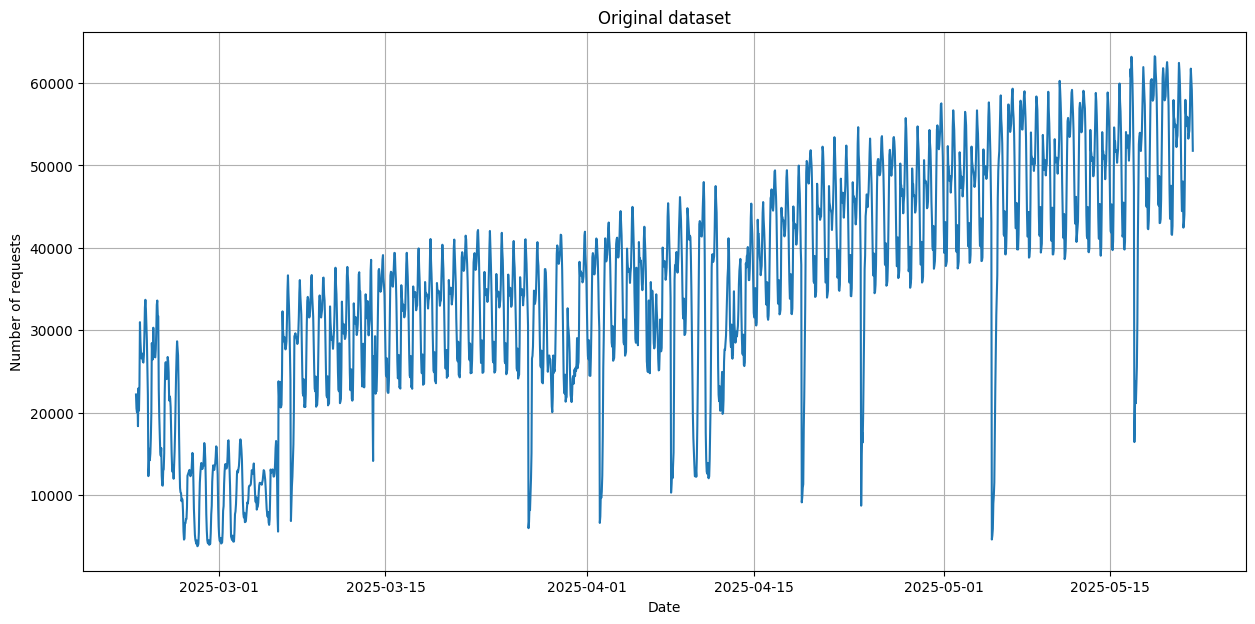

In [14]:
# Plot the original data
plt.figure(figsize=(15, 7))
plt.plot(df.index, df['target'])
plt.title('Original dataset')
plt.xlabel('Date')
plt.ylabel('Number of requests')
plt.grid(True)
plt.show()

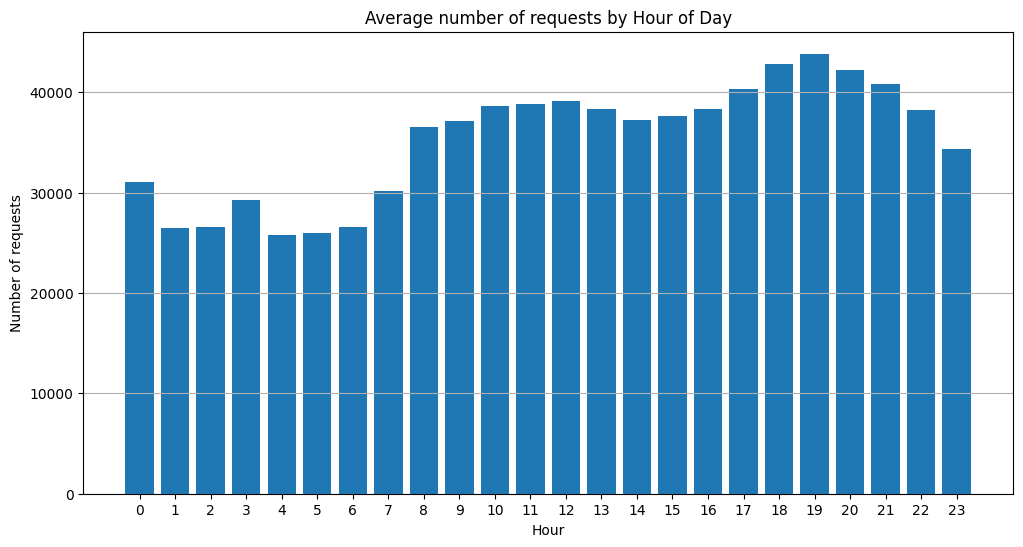

In [15]:
# Visualize by hour of day
hourly_avg = df.groupby(df.index.hour)['target'].mean()
plt.figure(figsize=(12, 6))
plt.bar(hourly_avg.index, hourly_avg.values)
plt.title('Average number of requests by Hour of Day')
plt.xlabel('Hour')
plt.ylabel('Number of requests')
plt.xticks(range(0, 24))
plt.grid(True, axis='y')
plt.show()

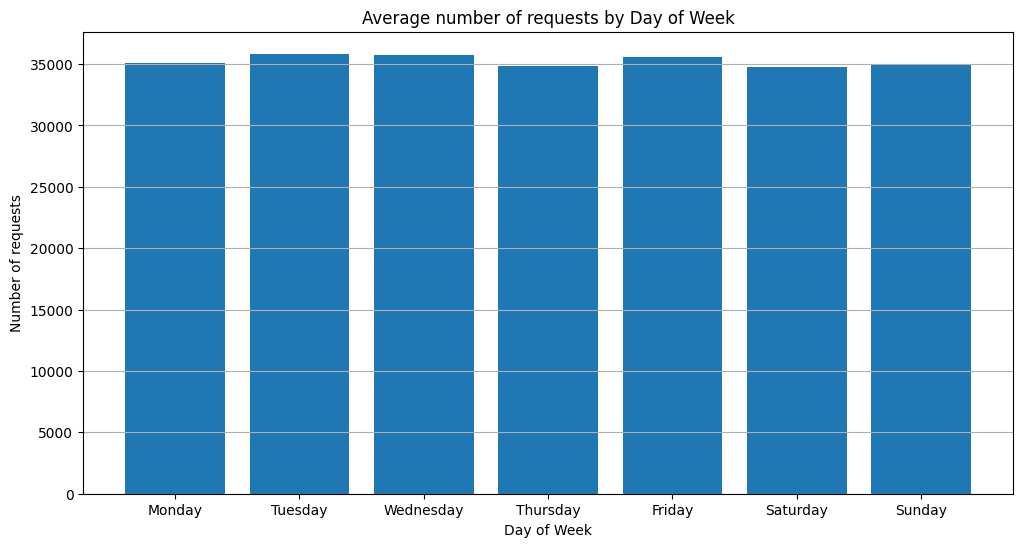

In [16]:

# Visualize by day of week
daily_avg = df.groupby(df.index.dayofweek)['target'].mean()
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
plt.figure(figsize=(12, 6))
plt.bar(days, daily_avg.values)
plt.title('Average number of requests by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Number of requests')
plt.grid(True, axis='y')
plt.show()

In [6]:
# Split into training (80%) and testing (20%)
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]

ADF Statistic: -1.454656
p-value: 0.555811
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568
Series is non-stationary, differencing will be applied


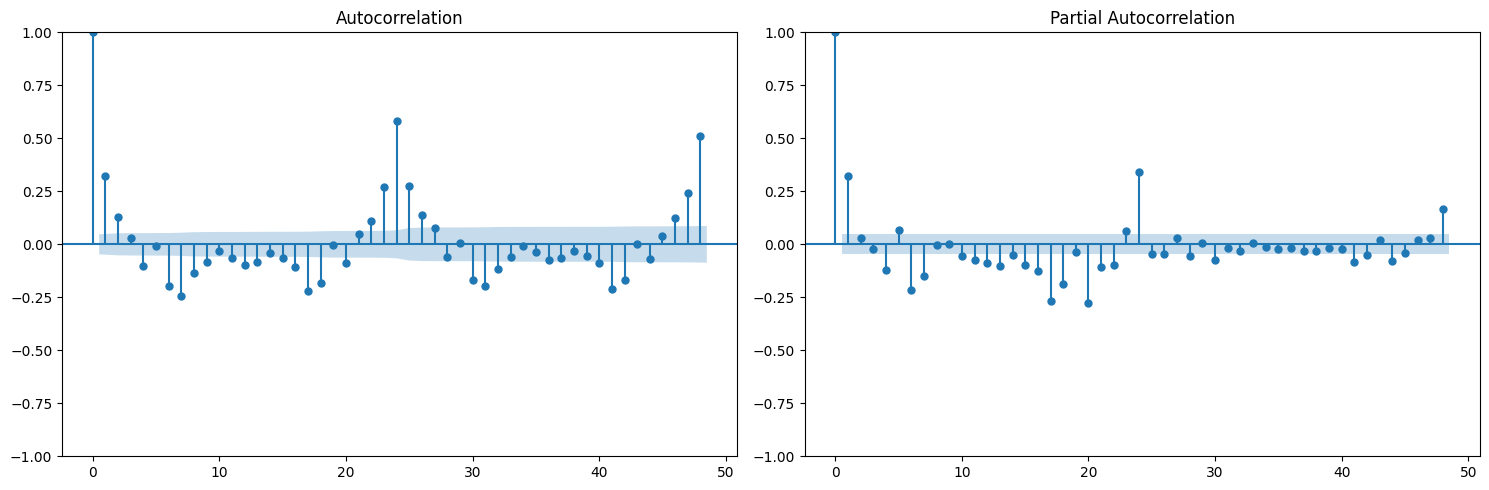

In [7]:
# Check stationarity of the scaled series
result = adfuller(train['target'].values)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

# Determine if differencing is needed
if result[1] > 0.05:
    print("Series is non-stationary, differencing will be applied")
    # Apply differencing
    train_diff = train['target'].diff().dropna()
    stationary_series = train_diff
else:
    print("Series is stationary")
    stationary_series = train['target']

# Plot ACF and PACF
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
sm.graphics.tsa.plot_acf(stationary_series, lags=48, ax=axes[0])
sm.graphics.tsa.plot_pacf(stationary_series, lags=48, ax=axes[1])
plt.tight_layout()
plt.show()

In [8]:
# Auto ARIMA to find optimal parameters
print("Running auto_arima to find optimal model parameters...")
auto_model = auto_arima(
    train['target'],
    seasonal=True,
    m=24,  # Daily seasonality ( 24 hours)
    start_p=0, start_q=0,
    max_p=3, max_q=3,
    start_P=0, start_Q=0,
    max_P=3, max_Q=3,
    d=1, D=1,
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True
)

print(f"Best model: {auto_model.order}, seasonal_order: {auto_model.seasonal_order}")


Running auto_arima to find optimal model parameters...
Performing stepwise search to minimize aic


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(0,1,0)[24]             : AIC=31538.693, Time=0.38 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(1,1,0)[24]             : AIC=31185.850, Time=13.48 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,1,1)[24]             : AIC=inf, Time=16.81 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(0,1,0)[24]             : AIC=31516.527, Time=0.53 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(2,1,0)[24]             : AIC=31084.812, Time=10.77 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(3,1,0)[24]             : AIC=30922.156, Time=63.06 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(3,1,1)[24]             : AIC=inf, Time=127.91 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(2,1,1)[24]             : AIC=inf, Time=60.31 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(3,1,0)[24]             : AIC=30951.817, Time=17.29 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(3,1,0)[24]             : AIC=30924.050, Time=81.18 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(3,1,0)[24]             : AIC=30924.101, Time=104.20 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(3,1,0)[24]             : AIC=30922.711, Time=67.89 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(3,1,0)[24]             : AIC=inf, Time=153.19 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(3,1,0)[24] intercept   : AIC=30924.156, Time=73.97 sec

Best model:  ARIMA(1,1,0)(3,1,0)[24]          
Total fit time: 790.984 seconds
Best model: (1, 1, 0), seasonal_order: (3, 1, 0, 24)


In [9]:
# Fit the SARIMA model with the optimal parameters
best_order = auto_model.order
best_seasonal_order = auto_model.seasonal_order

# Train the model on the training data
model = sm.tsa.statespace.SARIMAX(
    train['target'],
    order=best_order,
    seasonal_order=best_seasonal_order,
    enforce_stationarity=False,
    enforce_invertibility=False
)
best_model = model.fit(disp=False)
print(best_model.summary())


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                             target   No. Observations:                 1708
Model:             SARIMAX(1, 1, 0)x(3, 1, 0, 24)   Log Likelihood              -14772.781
Date:                            Sun, 11 May 2025   AIC                          29555.563
Time:                                    10:39:00   BIC                          29582.483
Sample:                                02-22-2025   HQIC                         29565.556
                                     - 05-04-2025                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1274      0.013      9.707      0.000       0.102       0.153
ar.S.L24      -0.6367      0.009   

In [10]:

# Generate forecasts for the entire test period
pred = best_model.get_forecast(steps=len(test))
pred_ci = pred.conf_int()
pred_mean = pred.predicted_mean

# Evaluate model performance on test set
mae = mean_absolute_error(test['target'], pred_mean)
mse = mean_squared_error(test['target'], pred_mean)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(test['target'], pred_mean)
print(f"MAE: {mae:.4f}")

print(f"RMSE: {rmse:.4f}")

# Also compute relative metrics

print(f"MAPE: {mape:.4f}")  # Mean Absolute Percentage Error


MAE: 2691.5035
RMSE: 5960.8065
MAPE: 0.1295


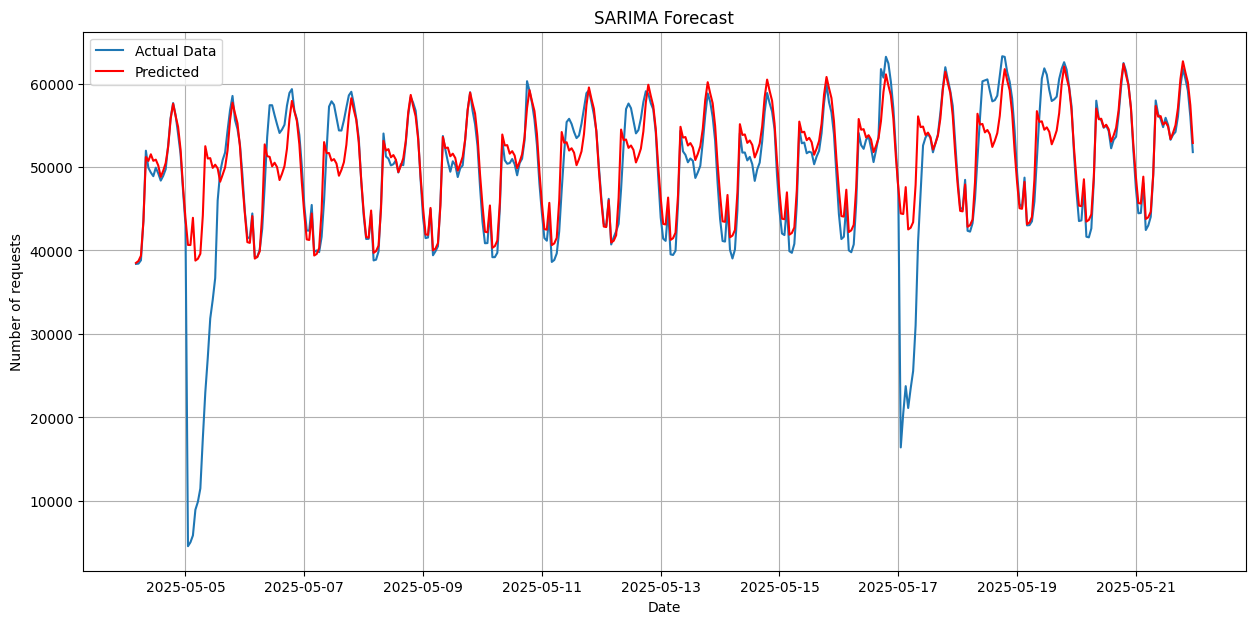

In [11]:
# Plot actual vs predicted for the test period (in original scale)
plt.figure(figsize=(15, 7))
plt.plot(test.index, test['target'], label='Actual Data')
plt.plot(test.index, pred_mean, label='Predicted', color='red')
plt.title('SARIMA Forecast')
plt.xlabel('Date')
plt.ylabel('Number of requests')
plt.legend()
plt.grid(True)
plt.show()


df_results = pd.DataFrame({"Predicted": pred_mean})
df_results.to_csv("/content/drive/MyDrive/Colab Notebooks/results/SARIMA_test_results.csv", index=False)

MAE: 49896.6784
RMSE: 50212.7340
MAPE: 384.3320


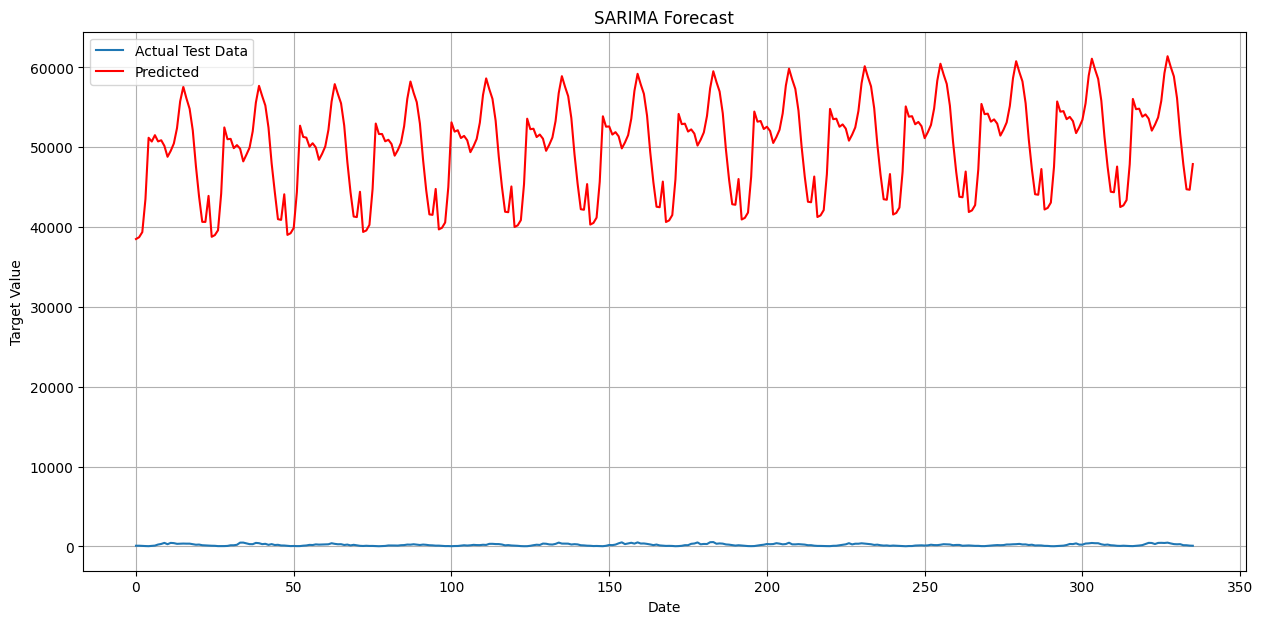

In [12]:
# test model

df_csv = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/synthetic_dataset.csv')


# Generate forecasts for the entire test period
pred = best_model.get_forecast(steps=len(df_csv[['target']]))
pred_ci = pred.conf_int()
pred_mean = pred.predicted_mean


# Evaluate model performance
mae = mean_absolute_error(df_csv['target'], pred_mean)
mse = mean_squared_error(df_csv['target'], pred_mean)
rmse = np.sqrt(mse)
print(f"MAE: {mae:.4f}")

print(f"RMSE: {rmse:.4f}")

# Also compute relative metrics
mape = mean_absolute_percentage_error(df_csv['target'], pred_mean)
print(f"MAPE: {mape:.4f}")  # Mean Absolute Percentage Error

# Plot actual vs predicted for the test period (in original scale)
plt.figure(figsize=(15, 7))
plt.plot(df_csv.index, df_csv['target'], label='Actual Test Data')
plt.plot(df_csv.index, pred_mean, label='Predicted', color='red')
plt.title('SARIMA Forecast')
plt.xlabel('Date')
plt.ylabel('Target Value')
plt.legend()
plt.grid(True)
plt.show()


df_results = pd.DataFrame({"Predicted": pred_mean})
df_results.to_csv("/content/drive/MyDrive/Colab Notebooks/results/SARIMA_synthetic_results.csv", index=False)